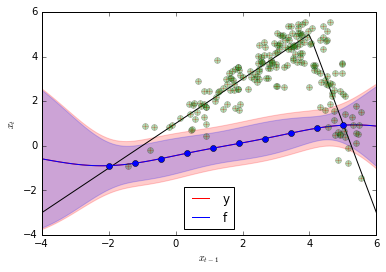

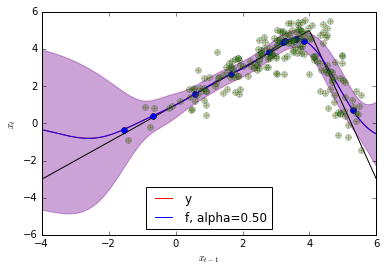

{   'C': array([[ 0.99897241]]),
    'R': array([-2.55632565]),
    'ls': array([ 0.27517323]),
    'sf': array([ 0.76942299]),
    'sn': array(-0.2410102283373783),
    'zu': array([[-1.55184993],
       [-0.67595985],
       [ 0.58369543],
       [ 1.66043333],
       [ 3.2610383 ],
       [ 2.79904589],
       [ 3.84296261],
       [ 3.59606042],
       [ 3.20442391],
       [ 5.28560489]])}


In [1]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout
import numpy as np
import scipy.stats
import matplotlib.pylab as plt
import os, sys
sys.path.insert(0, "../")
import geepee.aep_models as aep
import pdb
%matplotlib inline

np.random.seed(42)

def test_kink():
    def kink_true(x):
        fx = np.zeros(x.shape)
        for t in range(x.shape[0]):
            xt = x[t]
            if xt < 4:
                fx[t] = xt + 1
            else:
                fx[t] = -4*xt + 21
        return fx

    def kink(T, process_noise, obs_noise, xprev=None):
        if xprev is None:
            xprev = np.random.randn()
        y = np.zeros([T, ])
        x = np.zeros([T, ])
        xtrue = np.zeros([T, ])
        for t in range(T):
            if xprev < 4:
                fx = xprev + 1
            else:
                fx = -4*xprev + 21

            xtrue[t] = fx
            x[t] = fx + np.sqrt(process_noise)*np.random.randn()
            xprev = x[t]
            y[t] = x[t] + np.sqrt(obs_noise)*np.random.randn()

        return xtrue, x, y

    T = 200
    process_noise = 0.2
    obs_noise = 0.1
    (xtrue, x, y) = kink(T, process_noise, obs_noise)
    y_train = np.reshape(y, [y.shape[0], 1])
    # pdb.set_trace()

    alpha = 0.5
    Dlatent = 1
    Dobs = 1
    M = 10
    C = 1*np.ones((1, 1))
    R = np.ones(1)*np.log(obs_noise)/2
    lls = np.reshape(np.log(2), [Dlatent, ])
    lsf = np.reshape(np.log(2), [1, ])
    zu = np.linspace(-2, 5, M)
    zu = np.reshape(zu, [M, 1])
    lsn = np.log(process_noise)/2
    params = {'ls': lls, 'sf': lsf, 'sn': lsn, 'R': R, 'C': C, 'zu': zu}

    # create model
    model = aep.SGPSSM(y_train, Dlatent, M, 
        lik='Gaussian', prior_mean=0, prior_var=1000)
    hypers = model.init_hypers(y_train)
    for key in params.keys():
        hypers[key] = params[key]
    model.update_hypers(hypers, alpha)
    model.plot()
    # optimise
    # model.set_fixed_params(['sn', 'R', 'zu', 'ls', 'sf', 'C', 'x_up_1', 'x_up_2', 'x_prev_1', 'x_prev_2', 'x_next_1', 'x_next_2'])
#     model.set_fixed_params(['sn', 'R', 'zu', 'ls', 'sf', 'C'])
    model.set_fixed_params(['x_up_1', 'x_up_2'])
    model.set_fixed_params(['x_prev_1', 'x_prev_2'])
    model.set_fixed_params(['x_next_1', 'x_next_2'])
    model.optimise(method='L-BFGS-B', alpha=alpha, maxiter=3000, reinit_hypers=False)
    
    # make prediction on some test inputs
    N_test = 200
    x_test = np.linspace(-4, 6, N_test)
    x_test = np.reshape(x_test, [N_test, 1])
    zu = model.sgp_layer.zu
    mu, vu = model.predict_f(zu)
    mf, vf = model.predict_f(x_test)
    my, vy = model.predict_y(x_test)
    # plot function
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_test[:,0], kink_true(x_test[:,0]), '-', color='k')
    ax.plot(x_test[:,0], my[:,0], '-', color='r', label='y')
    ax.fill_between(
        x_test[:,0], 
        my[:,0] + 2*np.sqrt(vy[:, 0, 0]), 
        my[:,0] - 2*np.sqrt(vy[:, 0, 0]), 
        alpha=0.2, edgecolor='r', facecolor='r')
    ax.plot(zu, mu, 'ob')
    ax.plot(x_test[:,0], mf[:,0], '-', color='b', label='f, alpha=%.2f' % alpha)
    ax.fill_between(
        x_test[:,0], 
        mf[:,0] + 2*np.sqrt(vf[:,0]), 
        mf[:,0] - 2*np.sqrt(vf[:,0]), 
        alpha=0.2, edgecolor='b', facecolor='b')
    ax.plot(
        model.emi_layer.y[0:model.N-1], 
        model.emi_layer.y[1:model.N], 
        'r+', alpha=0.5)
    mx, vx = model.get_posterior_x()
    ax.plot(mx[0:model.N-1], mx[1:model.N], 'og', alpha=0.3)
    ax.set_xlabel(r'$x_{t-1}$')
    ax.set_ylabel(r'$x_{t}$')
    ax.legend(loc='lower center')
    
#     # create model
#     prev_hypers = model.get_hypers()
#     model = aep.SGPSSM(y_train, Dlatent, M, 
#         lik='Gaussian', prior_mean=0, prior_var=1000)
#     model.update_hypers(prev_hypers, alpha)
#     model.plot()
#     # optimise
# #     model.set_fixed_params(['sn', 'R', 'zu', 'ls', 'sf', 'C', 'x_up_1', 'x_up_2', 'x_prev_1', 'x_prev_2', 'x_next_1', 'x_next_2'])
#     model.set_fixed_params(['sn', 'R', 'zu', 'ls', 'sf', 'C'])
# #     model.set_fixed_params(['x_up_1', 'x_up_2'])
# #     model.set_fixed_params(['x_prev_1', 'x_prev_2'])
# #     model.set_fixed_params(['x_next_1', 'x_next_2'])
#     model.optimise(method='L-BFGS-B', alpha=alpha, maxiter=3000, reinit_hypers=False)
    
#     # make prediction on some test inputs
#     N_test = 200
#     x_test = np.linspace(-4, 6, N_test)
#     x_test = np.reshape(x_test, [N_test, 1])
#     zu = model.sgp_layer.zu
#     mu, vu = model.predict_f(zu)
#     mf, vf = model.predict_f(x_test)
#     my, vy = model.predict_y(x_test)
#     # plot function
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(x_test[:,0], kink_true(x_test[:,0]), '-', color='k')
#     ax.plot(x_test[:,0], my[:,0], '-', color='r', label='y')
#     ax.fill_between(
#         x_test[:,0], 
#         my[:,0] + 2*np.sqrt(vy[:, 0, 0]), 
#         my[:,0] - 2*np.sqrt(vy[:, 0, 0]), 
#         alpha=0.2, edgecolor='r', facecolor='r')
#     ax.plot(zu, mu, 'ob')
#     ax.plot(x_test[:,0], mf[:,0], '-', color='b', label='f, alpha=%.2f' % alpha)
#     ax.fill_between(
#         x_test[:,0], 
#         mf[:,0] + 2*np.sqrt(vf[:,0]), 
#         mf[:,0] - 2*np.sqrt(vf[:,0]), 
#         alpha=0.2, edgecolor='b', facecolor='b')
#     ax.plot(
#         model.emi_layer.y[0:model.N-1], 
#         model.emi_layer.y[1:model.N], 
#         'r+', alpha=0.5)
#     mx, vx = model.get_posterior_x()
#     ax.plot(mx[0:model.N-1], mx[1:model.N], 'og', alpha=0.3)
#     ax.set_xlabel(r'$x_{t-1}$')
#     ax.set_ylabel(r'$x_{t}$')
#     ax.legend(loc='lower center')

    plt.show()
    
    opt_hypers = model.get_hypers()
    import pprint
    pp = pprint.PrettyPrinter(indent=4)
    keys = ['ls', 'sf', 'zu', 'sn', 'C', 'R']
    params_dict = {}
    for key in keys:
        params_dict[key] = opt_hypers[key]
    pp.pprint(params_dict)

test_kink()